In [8]:

import jax
import jax.numpy as jnp
import numpy as np
from stljax.formula import *
from stljax.viz import *
import matplotlib.pyplot as plt
import equinox as eqx
from typing import Callable
import stljax
from jax import random

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from stljax.utils import smooth_mask, anneal


from matplotlib import rc
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)


Plotting smooth mask with different scaling parameter

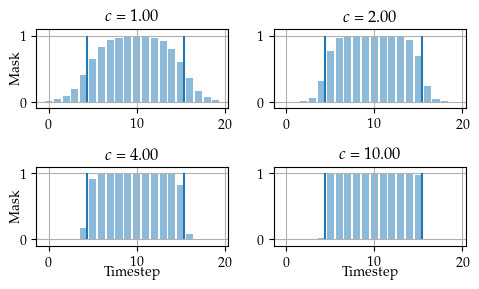

In [9]:
T = 20
plt.figure(figsize=(5,3))
a = 0.22
b = 0.77
for (i,s) in enumerate([1., 2., 4, 10]):
    plt.subplot(2,2,i+1)
    plt.bar(range(T), smooth_mask(T, a, b, s), alpha=0.5)
    plt.vlines([a*T, b*T], 0, 1)
    plt.grid()
    plt.ylim([-0.1, 1.1])
    plt.title("$c$ = %.2f"%s)
    if i in [2, 3]:
        plt.xlabel("Timestep",labelpad=-3)
    if i in [0,2]:
        plt.ylabel("Mask",labelpad=-3)
plt.tight_layout()
# plt.savefig("figs/smooth_mask.png", dpi=200, transparent=True)

In [10]:
pred = Predicate('x', lambda x: x)
dp = DifferentiableAlways(pred > 0.)
rec = AlwaysRecurrent(pred > 0.)
p = Always(pred > 0.)

In [11]:
@functools.partial(jax.jit, static_argnames=("approx_method"))
def foo(signal, t_start, t_end, scale, approx_method="true", temperature=20., delta=1E-3):
    return dp.robustness(signal, t_start=t_start, t_end=t_end, scale=scale, approx_method=approx_method, temperature=temperature, delta=delta)

grad_foo = jax.jit(jax.grad(foo, [1, 2]))

@functools.partial(jax.jit, static_argnames=("approx_method"))
def loss(signal, t_start, t_end, scale, approx_method, temperature, coeff=0.05):
    rob_ = foo(signal, t_start, t_end, scale, approx_method, temperature)
    rob = jax.nn.relu(-jnp.where(t_start < (t_end - 0.05), rob_, jnp.nan))
    return rob + coeff * (t_start - t_end)

@functools.partial(jax.jit, static_argnames=("approx_method"))
def loss_batch(signals, t_start, t_end, scale, approx_method, temperature, coeff=0.05):
    return jax.vmap(loss, [0, None, None, None, None, None, None])(signals, t_start, t_end, scale, approx_method, temperature, coeff).mean()

grad_loss = jax.jit(jax.grad(loss, [1,2]), static_argnames=("approx_method"))
grad_loss_batch = jax.jit(jax.grad(loss_batch, [1,2]), static_argnames=("approx_method"))


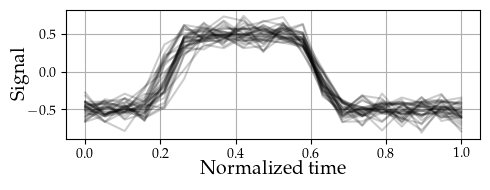

In [12]:
T = 20
fontsize = 14
true_t_start = 0.21
true_t_end = 0.59
bs = 32


key = random.key(1701)
signals = jax.vmap(smooth_mask, [None, 0, None, None])(T, true_t_start + 0.02 * random.normal(key, shape=(bs,)), true_t_end, 3.) + random.normal(key, shape=(bs, T,)) * 0.1 - 0.5
# signals = (smooth_mask(T, true_t_start, true_t_end, 200.) - 0.5) + random.normal(key, shape=(bs, T,)) * 0.1
plt.figure(figsize=(5,2))
# plt.subplot(1,2,1)
plt.plot(jnp.linspace(0,1,T), signals.T, color="black", alpha=0.2)
plt.xlabel("Normalized time", fontsize=fontsize, labelpad=-1)
plt.ylabel("Signal", fontsize=fontsize, labelpad=-1)

# plt.axis("equal")
plt.grid()

plt.tight_layout()

# plt.subplot(1,2,2)
# plt.plot(signals[0])
# # plt.axis("equal")
# plt.grid()

In [14]:
scale = 3000.
temperature = 100.
approx_method = "true"
foo(signals[0], true_t_start, true_t_end, scale, approx_method="true", temperature=temperature)

Array(0.49465644, dtype=float32)

In [15]:
def visualize_smooth_time_interval_(signal, t_start, t_end, scale, approx_method, temperature):
    fontsize = 14
    delta = 1E-3
    T = signal.shape[0]
    xs = jnp.linspace(0., 1., T)
    mask = smooth_mask(T, t_start, t_end, scale)
    masked_filtered = jnp.where(mask > delta, mask, jnp.nan)
    plt.plot(xs * T, signal, label="Signal")
    plt.bar(xs * T, masked_filtered, label="Mask", color="C1", alpha=0.3)
    ss = dp.subformula(signal)
    # jnp.where(padded_smooth_time_mask, signal_padded * padded_smooth_time_mask, mask_value)
    masked_signal = jnp.where(mask > delta, ss * mask, jnp.nan)
    plt.plot(xs * T, masked_signal, "o-", label="Masked signal", color="C2")

    rob = foo(signal, t_start=t_start, t_end=t_end, scale=scale, approx_method=approx_method, temperature=temperature)
    plt.hlines(rob, 0, T, color="red", label="Robustness")
    # plt.hlines(delta, 0, 1, color="green", label="Delta")
    
    
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("$\\rho$ = %.3f (c = %.2f, $\\tau_\\mathrm{%s}=$%.2f)"%(rob, scale, app, temperature))
    else:
        plt.title("$\\rho$ = %.3f (c = %.2f)"%(rob, scale))
        
    # plt.ylim([-1.5, 1.5])
    plt.grid(zorder=-5, alpha=0.2)
    plt.legend(ncol=2)
    plt.xlabel("Normalized time", fontsize=fontsize)
    plt.ylabel("Signal magnitude", fontsize=fontsize)

def visualize_smooth_time_interval(signal, t_start, t_end, scale, approx_method, temperature):
    plt.figure(figsize=(5,3))
    visualize_smooth_time_interval_(signal, t_start, t_end, scale, approx_method, temperature)


def visualize_loss_landscape(loss_func, signal, scale, approx_method, temperature, coeff):
    N = 100
    fontsize = 14
    levels = 10
    T = signal.shape[0]
    starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
    losses = jax.vmap(loss_func, [None, 0, 0, None, None, None, None])(signal, starts.reshape([-1,1]), ends.reshape([-1,1]), scale, approx_method, temperature, coeff).reshape([N,N])
    
    plt.contourf(starts, ends, losses, levels=levels, cmap="jet", alpha=0.4)
    plt.colorbar()
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("Loss landscape \n  (c = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(scale, app, temperature))
    else:
        plt.title("Loss landscape \n (c = %.2f)"%(scale))
    plt.xlabel("$a$", fontsize=fontsize, labelpad=-3)
    plt.ylabel("$b$", fontsize=fontsize, labelpad=-3)
    plt.grid(zorder=-5, alpha=0.2)


def visualize_gradients(i, grad_function, signal, scale, approx_method, temperature, coeff):
    N = 100
    levels = 10
    fontsize = 14
    starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
    
    da, db = jax.vmap(grad_function, [None, 0, 0, None, None, None, None])(signal, starts.reshape([-1]), ends.reshape([-1]), scale, approx_method, temperature, coeff)
    da = jnp.where(starts < (ends - 0.05), da.reshape([N,N]), jnp.nan)
    db = jnp.where(starts < (ends - 0.05), db.reshape([N,N]), jnp.nan)
    
    if i == 0:
        dd = da
    else:
        dd = db
    plt.contourf(starts, ends, jnp.abs(dd), levels=levels, alpha=0.4)
    plt.colorbar()
    
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("(s = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(scale, app, temperature))
    else:
        plt.title("(s = %.2f)"%(scale))
    plt.xlabel("$t_\\mathrm{start}$", fontsize=fontsize)
    plt.ylabel("$t_\\mathrm{end}$", fontsize=fontsize)
    plt.grid(zorder=-5, alpha=0.2)
    
    


In [16]:
approx_method = "true"
start_index_slider = widgets.FloatSlider(value=0.21, min=0.0, max=1., step=0.01, description='t_start: ')
end_index_slider = widgets.FloatSlider(value=0.59, min=0.0, max=1., step=0.01, description='t_end: ')
scale_index_slider = widgets.FloatSlider(value=1., min=1., max=50, step=1, description='scale: ')
temp_index_slider = widgets.FloatSlider(value=1., min=1., max=100, step=1, description='temperature: ')
delta_index_slider = widgets.FloatSlider(value=3, min=1., max=12, step=1, description='delta: ')

interact(visualize_smooth_time_interval, signal=widgets.fixed(signals[0]), 
                                         t_start=start_index_slider,
                                         t_end=end_index_slider,
                                         scale=scale_index_slider,
                                         approx_method=widgets.fixed(approx_method),
                                         temperature=temp_index_slider)

/Users/karen/venvs/test/lib/python3.12/site-packages/ipywidgets/widgets/interaction.py:43: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  from ipykernel.pylab.backend_inline import flush_figures


interactive(children=(FloatSlider(value=0.21, description='t_start: ', max=1.0, step=0.01), FloatSlider(value=…

<function __main__.visualize_smooth_time_interval(signal, t_start, t_end, scale, approx_method, temperature)>

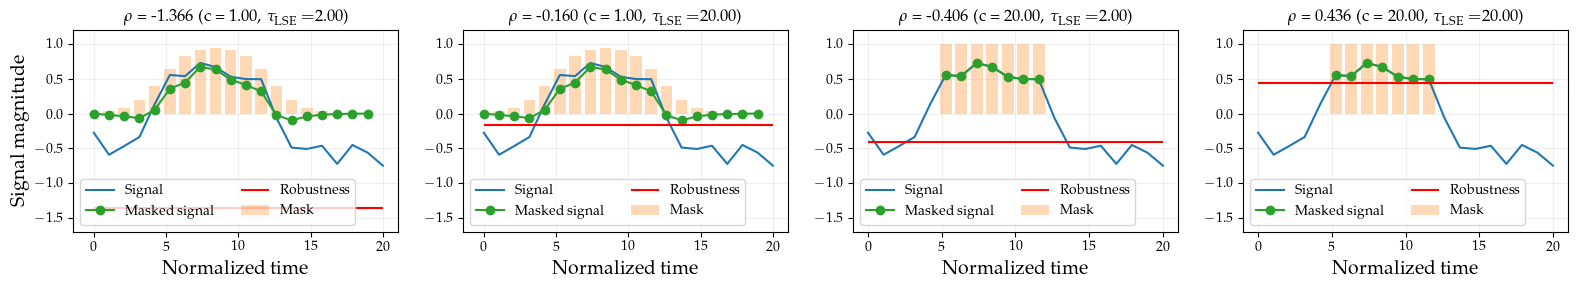

In [17]:
approx_method = "logsumexp"
plt.figure(figsize=(16,3))
scales = [1., 20.]
temps = [2., 20.]
i = 1
for s in scales:
    for t in temps:
        plt.subplot(1,4,i)
        visualize_smooth_time_interval_(signals[0], true_t_start+0.01, true_t_end-0.01, s, approx_method, t)
        plt.ylim([-1.7, 1.2])
        # if i in [1,2]:
        #     plt.xlabel("")
        if i in [2,3,4]:
            plt.ylabel("")
        i += 1
plt.tight_layout()

In [18]:
def plot_loss_landscape(signal, s, e, scale, approx_method, temperature, coeff):
    N = 100
    ticks = jnp.linspace(0, 1, N)
    starts, ends = jnp.meshgrid(ticks, ticks)
    losses = jax.vmap(loss, [None, 0, 0, None, None, None, None])(signal, starts.reshape([-1,1]), ends.reshape([-1,1]), scale, approx_method, temperature, coeff).reshape([N,N])
    # s = starts[0,t_start_idx]
    # e = ends[t_end_idx, 0]
    ell = loss(signal, s, e, scale, approx_method, temperature, coeff)
    
    plt.figure(figsize=(18,3))
    
    plt.subplot(1,5,1)
    
    visualize_smooth_time_interval_(signal, s, e, scale, approx_method, temperature)
    
    plt.subplot(1,5,2)
    visualize_loss_landscape(loss, signal, scale, approx_method, temperature, coeff)
    plt.vlines(s, 0, 1, color="red")
    plt.hlines(e, 0, 1, color="blue")
    if approx_method != "true":
        plt.title("Loss landscape, $\\ell=$%.5f \n (s = %.2f, $\\tau$ = %.2f)"%(ell, scale, temperature))
    else:
        plt.title("Loss landscape, $\\ell=$%.5f \n (s = %.2f)"%(ell, scale))


    plt.subplot(2,5,3)
    plt.title("$t_\\mathrm{end}$=%.2f"%e)
    ls = jax.vmap(loss, [None, 0, None, None, None, None, None])(signal, ticks, e, scale, approx_method, temperature, coeff)
    plt.plot(ticks, ls, color="blue")
    plt.vlines(s, 0,0.1)
    plt.xlim([0,1])
    plt.grid()
    
    plt.subplot(2,5,8)
    plt.title("$t_\\mathrm{start}$=%.2f"%s)
    ls = jax.vmap(loss, [None, None, 0, None, None, None, None])(signal, s, ticks, scale, approx_method, temperature, coeff)
    plt.plot(ticks, ls, color="red")
    plt.vlines(e, 0,0.1)
    plt.xlim([0,1])
    plt.grid()
    
    # gradients
    a, b = grad_loss(signal, s, e, scale, approx_method, temperature)
    
    plt.subplot(1,5,4)
    visualize_gradients(0, grad_loss, signal, scale, approx_method, temperature, coeff)
    plt.vlines(s, 0, 1, color="red")
    plt.hlines(e, 0, 1, color="blue")
    if approx_method != "true":
        plt.title("$\\frac{\\partial\\ell}{\\partial t_\\mathrm{start}}$ = %.2f \n (s = %.2f, $\\tau$ = %.2f)"%(a, scale, temperature))
    else:
        plt.title("$\\frac{\\partial\\ell}{\\partial t_\\mathrm{start}}$ = %.2f \n (s = %.2f)"%(a, scale))
    
    plt.subplot(1,5,5)
    visualize_gradients(1, grad_loss, signal, scale, approx_method, temperature, coeff)
    plt.vlines(s, 0, 1, color="red")
    plt.hlines(e, 0, 1, color="blue")
    if approx_method != "true":
        plt.title("$\\frac{\\partial\\ell}{\\partial t_\\mathrm{end}}$ = %.2f \n (s = %.2f, $\\tau$ = %.2f)"%(b, scale, temperature))
    else:
        plt.title("$\\frac{\\partial\\ell}{\\partial t_\\mathrm{end}}$ = %.2f \n (s = %.2f)"%(b, scale))
    
    plt.tight_layout()



start_index_slider = widgets.FloatSlider(value=0.21, min=0.0, max=1., step=0.01, description='t_start: ')
end_index_slider = widgets.FloatSlider(value=0.59, min=0.0, max=1., step=0.01, description='t_end: ')
scale_index_slider = widgets.FloatSlider(value=1., min=.1, max=10, step=.5, description='scale: ')
temp_index_slider = widgets.FloatSlider(value=1., min=.1, max=10, step=.5, description='temperature: ')
delta_index_slider = widgets.FloatSlider(value=3, min=1., max=12, step=1, description='delta: ')

# start_index_slider = widgets.IntSlider(value=23, min=0, max=99, step=1, description='t_start: ')
# end_index_slider = widgets.IntSlider(value=58, min=0, max=99, step=1, description='t_end: ')
coeff_slider = widgets.FloatSlider(value=0.01, min=0., max=1., step=0.02, description='coeff: ')
approx_method_slider = widgets.Dropdown(
    options=['true', "logsumexp", "softmax"],
    value='true',
    description='approx method:',
    disabled=False,
)
interact(plot_loss_landscape, signal=widgets.fixed(signals[0]), 
                              s=start_index_slider,
                              e=end_index_slider,
                              scale=scale_index_slider,
                              approx_method=approx_method_slider,
                              temperature=temp_index_slider,
                              coeff=coeff_slider)


interactive(children=(FloatSlider(value=0.21, description='t_start: ', max=1.0, step=0.01), FloatSlider(value=…

<function __main__.plot_loss_landscape(signal, s, e, scale, approx_method, temperature, coeff)>

In [19]:
approx_method = "logsumexp"
temperature = 1.
scale = 1.
a = -2.
b = 2.
lr = 1E-2
max_steps = 5000
scale_start = 1.
scale_end = 20
temperature_start = 1.
temperature_end = 20
a_list = [a]
b_list = [b]
coeff_start = 0.1
coeff_end = 0.


for i in range(max_steps):
    j = (i / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    c = (1 - j) * coeff_start + j * coeff_end
    a_ = jax.nn.sigmoid(a)
    b_ = jax.nn.sigmoid(b)
    g = grad_loss_batch(signals, a_, b_, s, approx_method, t, c)
    a -= lr * g[0] * a_ * (1 - a_)
    b -= lr * g[1] * b_ * (1 - b_)
    a_list.append(a)
    b_list.append(b)
    # print(a,b)
a_list = jnp.stack(a_list)
b_list = jnp.stack(b_list)

In [20]:
%timeit grad_loss_batch(signals, a_, b_, s, approx_method, t, c)

93.6 μs ± 1.01 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [21]:
coeff = 0.0
def visualize_results(i):
    a, b = jax.nn.sigmoid(a_list[i]), jax.nn.sigmoid(b_list[i])
    j = (i / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    c = (1 - j) * coeff_start + j * coeff_end
    plot_loss_landscape(signals[0], a, b, s, approx_method, t, c)
    
index_slider = widgets.IntSlider(value=0, min=0, max=max_steps-1, step=250, description='i: ')
interact(visualize_results, i=index_slider)

interactive(children=(IntSlider(value=0, description='i: ', max=4999, step=250), Output()), _dom_classes=('wid…

<function __main__.visualize_results(i)>

In [22]:
step_size = 50
def visualize_results(i, approx_method):
    a, b = jax.nn.sigmoid(a_list[i]), jax.nn.sigmoid(b_list[i])
    j = (i / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    ell = loss_batch(signals, a, b, s, approx_method, t, coeff)
    
    # plt.figure(figsize=(4,3))
    
    visualize_loss_landscape(loss_batch, signals, s, approx_method, t, coeff)
    plt.plot(jax.nn.sigmoid(a_list[::step_size]), jax.nn.sigmoid(b_list[::step_size]), "o-", markersize=3, color="black", linewidth=1)
    current_loss = loss_batch(signals, a, b, s, approx_method, t, coeff)
    gt_loss = loss_batch(signals, true_t_start, true_t_end, s, approx_method, t, coeff)
    plt.scatter([a], [b], marker="o", s=40, color="magenta", label="Current: %.3f"%current_loss, edgecolor="black", zorder=4)
    plt.scatter([true_t_start], [true_t_end], marker="*", s=100, color="orange", label="Ground truth: %.3f"%gt_loss, edgecolor="black", zorder=4)
    

    plt.vlines(a, 0, 1, color="red", linestyle='--')
    plt.hlines(b, 0, 1, color="blue", linestyle='--')
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("Loss = %.5f (c = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(ell, s, app, t))
    else:
        plt.title("Loss = %.5f (c = %.2f)"%(ell, s))
    plt.legend(loc="lower right")
index_slider = widgets.IntSlider(value=0, min=0, max=max_steps-1, step=step_size, description='i: ')
interact(visualize_results, i=index_slider, approx_method=widgets.fixed(approx_method))



interactive(children=(IntSlider(value=0, description='i: ', max=4999, step=50), Output()), _dom_classes=('widg…

<function __main__.visualize_results(i, approx_method)>

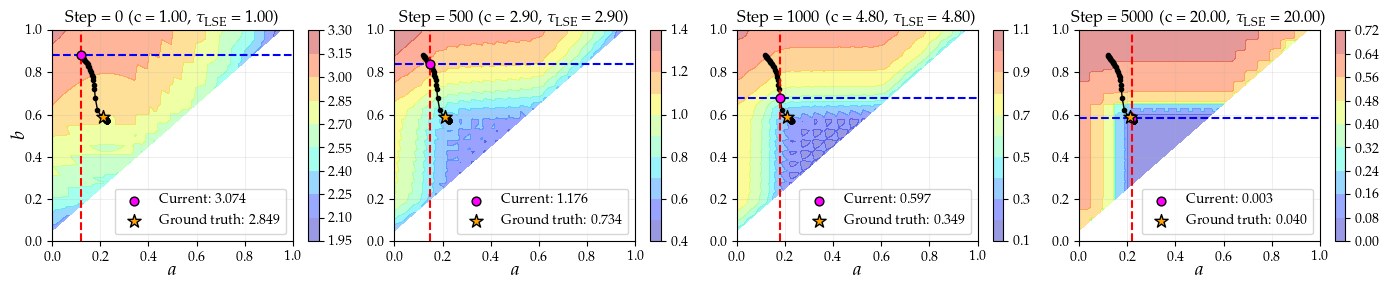

In [23]:
plt.figure(figsize=(14,3))
for (i,k) in enumerate([0, 500, 1000, 5000]):
    plt.subplot(1,4,i+1)
    visualize_results(k, approx_method)
    j = (k / max_steps)
    s = (1 - j) * scale_start + j * scale_end
    t = (1 - j) * temperature_start + j * temperature_end
    if approx_method != "true":
        match approx_method:
            case "logsumexp":
                app = "LSE"
            case "softmax":
                app = "soft"
        plt.title("Step = %i (c = %.2f, $\\tau_\\mathrm{%s}$ = %.2f)"%(k, s, app, t))
    else:
        plt.title("Step = %i (c = %.2f)"%(k, s))
        
    if i in [1, 2, 3]:
        # plt.xlabel("$a$", fontsize=fontsize, labelpad=-3)
        plt.ylabel("")
    plt.tight_layout()
    # plt.savefig("figs/gradient_descent_panel_LSE", dpi=200, transparent=True)

In [24]:
# brute force search
N = 300
scale = 200.
approx_method = "true"
temperature = 40.
coeff = 0.05

starts, ends = jnp.meshgrid(jnp.linspace(0,1, N), jnp.linspace(0,1, N))
n = jnp.nanargmin(jax.vmap(loss_batch, [None, 0, 0, None, None, None])(signals, starts.reshape([-1]), ends.reshape([-1]), scale, approx_method, temperature))
t_start, t_end = starts.reshape([-1])[n], ends.reshape([-1])[n]
# poo(signals[0], t_start, t_end, scale, approx_method, temperature)

In [53]:
%timeit jnp.nanargmin(jax.vmap(loss_batch, [None, 0, 0, None, None, None])(signals, starts.reshape([-1]), ends.reshape([-1]), scale, approx_method, temperature))

1.93 s ± 15.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%timeit jax.vmap(loss_batch, [None, 0, 0, None, None, None])(signals, starts.reshape([-1]), ends.reshape([-1]), scale, approx_method, temperature)

1.92 s ± 36.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
loss_batch(signals, t_start, t_end, scale, approx_method, temperature, 0.), loss_batch(signals, true_t_start, true_t_end, scale, approx_method, temperature, 0.)

(Array(0.00010173, dtype=float32), Array(0.00298509, dtype=float32))

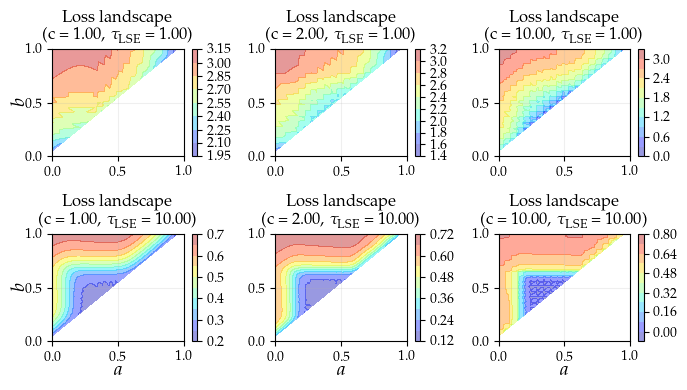

In [25]:
approx_method = "logsumexp"
plt.figure(figsize=(7,4))
scales = [1., 2., 10.]
temps = [1., 10.]
i = 1
for t in temps:
    for s in scales:
        plt.subplot(2,3,i)
        visualize_loss_landscape(loss_batch, signals, s, approx_method, t, coeff)
        if i in [1,2,3]:
            plt.xlabel("")
        if i in [2, 3,5, 6]:
            plt.ylabel("")
        i += 1
plt.tight_layout()

In [36]:
# analyzing gradients

pred = Predicate('x', lambda x: x)
rec = EventuallyRecurrent(pred > 0.)
ev = Eventually(pred > 0.)


In [37]:
T = 10
signal = jnp.arange(T) * 1.
# signal = jnp.array(np.random.randn(T))
signal_flip = jnp.flip(signal)


In [53]:
approx_method = "softmax"
temperature = 1.
axis = 0
keepdims = True



def test_grad(signal, temperature, approx_method):
    signal_flip = jnp.flip(signal)
    m = lambda x: maxish(x, axis=axis, keepdims=keepdims, approx_method=approx_method, temperature=temperature)
    # s0 = jnp.array([signal[0]])
    s0 = jnp.zeros(0)
    for s in signal_flip:
        s0 = m(jnp.concat([s0, jnp.array([s])]))
    return s0.squeeze() 


mask_grads = jax.grad(ev.robustness)(signal, approx_method=approx_method, temperature=temperature)
rec_grads = jax.grad(test_grad)(signal, temperature, approx_method)
# rec_grads = jax.grad(rec.robustness)(signal_flip, approx_method=approx_method, temperature=temperature)


In [54]:
def rec_robustness(signal, approx_method, temperature, padding=1E9):
    signal_flip = jnp.flip(signal)
    return rec(signal_flip, approx_method=approx_method, temperature=temperature, padding=padding)[-1]

In [55]:
def plot_gradients(temperature, approx_method):
    mask_grads = jax.grad(ev.robustness)(signal, approx_method=approx_method, temperature=temperature)
    # rec_grads = jnp.flip(jax.grad(rob, 1)(rec, signal_flip, approx_method=approx_method, temperature=temperature))
    rec_grads = jax.grad(test_grad)(signal, temperature, approx_method)
    # rec_grads = jax.grad(rec_robustness)(signal, approx_method=approx_method, temperature=temperature, padding=1E9)
    plt.bar(jnp.arange(T)-0.125, mask_grads, label="Mask", width=0.22, alpha=0.5)
    plt.bar(jnp.arange(T)+0.124, rec_grads, label="Rec.", width=0.22, alpha=0.5)
    height = max(mask_grads.max(), rec_grads.max())
    plt.vlines(jnp.argmax(signal), 0, height, zorder=-5, linestyle='--', label='True max')
    # plt.ylim([-0.2, 1.2])
    plt.grid()
    plt.title("$\\tau$ = %.2f"%temp)
    if i in [2, 3]:
        plt.xlabel("Timestep",labelpad=-2)
    if i in [0,2]:
        plt.ylabel("Gradient",labelpad=-2)

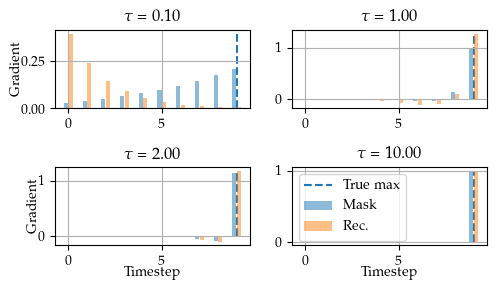

In [56]:
plt.figure(figsize=(5,3))
for (i, temp) in enumerate([0.1, 1., 2., 10.]):
    plt.subplot(2,2,i+1)
    plot_gradients(temp, approx_method)

plt.legend(loc="upper left")
plt.tight_layout()
# plt.savefig("figs/softmax_gradients.png", dpi=200, transparent=True)

In [57]:
temp_slider = widgets.FloatSlider(value=1., min=0.1, max=10., step=0.1, description='temperature:')
approx_method_slider = widgets.Dropdown(
    options=['true', "logsumexp", "softmax"],
    value='true',
    description='approx method:',
    disabled=False,
)
interact(plot_gradients, temperature=temp_slider, approx_method=approx_method_slider)


interactive(children=(FloatSlider(value=1.0, description='temperature:', max=10.0, min=0.1), Dropdown(descript…

<function __main__.plot_gradients(temperature, approx_method)>